In [1]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]    
        #print(mat_data1.shape)
        # Downsampling
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        #print(downsampled_data.shape)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)

(3300, 60, 1000)


In [3]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)
    


Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(5390, 60, 1000)


In [4]:
import numpy as np
num_control = Control30.shape[0]
num_concussed = Concussed52.shape[0]

desired_num_control = num_concussed
num_oversampling = desired_num_control // num_control
oversampled_control = np.repeat(Control30, num_oversampling, axis=0)
num_additional_samples = desired_num_control - oversampled_control.shape[0]
additional_control_indices = np.random.choice(num_control, size=num_additional_samples, replace=True)
additional_control = Control30[additional_control_indices]
balanced_data = np.concatenate([oversampled_control, additional_control, Concussed52], axis=0)
balanced_labels = np.concatenate([np.zeros(desired_num_control), np.ones(num_concussed)], axis=0)

print(balanced_data.shape) 
print(balanced_labels.shape) 


(10780, 60, 1000)
(10780,)


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, test_size=0.2, random_state=42)
eeg_input = Input(shape=(60, 1000))
conv1 = Conv1D(64, 3, activation='relu')(eeg_input)
maxpool1 = MaxPooling1D(2)(conv1)
flatten1 = Flatten()(maxpool1)
dropout1 = Dropout(0.5)(flatten1)

batchnorm1 = BatchNormalization()(dropout1)

dense1 = Dense(128, activation='relu')(batchnorm1)
dropout2 = Dropout(0.5)(dense1)

output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=eeg_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

history=model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=[lr_callback])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/100
34/34 [==============================] - 8s 206ms/step - loss: 0.8856 - accuracy: 0.5869 - val_loss: 0.8747 - val_accuracy: 0.5589 - lr: 0.0050
Epoch 2/100
34/34 [==============================] - 7s 192ms/step - loss: 0.6322 - accuracy: 0.6533 - val_loss: 0.6120 - val_accuracy: 0.6452 - lr: 0.0050
Epoch 3/100
34/34 [==============================] - 6s 186ms/step - loss: 0.5653 - accuracy: 0.6948 - val_loss: 0.5908 - val_accuracy: 0.7147 - lr: 0.0050
Epoch 4/100
34/34 [==============================] - 6s 187ms/step - loss: 0.5388 - accuracy: 0.7192 - val_loss: 0.5616 - val_accuracy: 0.7319 - lr: 0.0050
Epoch 5/100
34/34 [==============================] - 7s 199ms/step - loss: 0.5154 - accuracy: 0.7428 - val_loss: 0.5444 - val_accuracy: 0.7709 - lr: 0.0050
Epoch 6/100
34/34 [==============================] - 8s 223ms/step - loss: 0.4979 - accuracy: 0.7484 - val_loss: 0.5472 - val_accuracy: 0.7542 - lr: 0.0050
Epoch 7/100
34/34 [==============================] - 7s 216ms/st

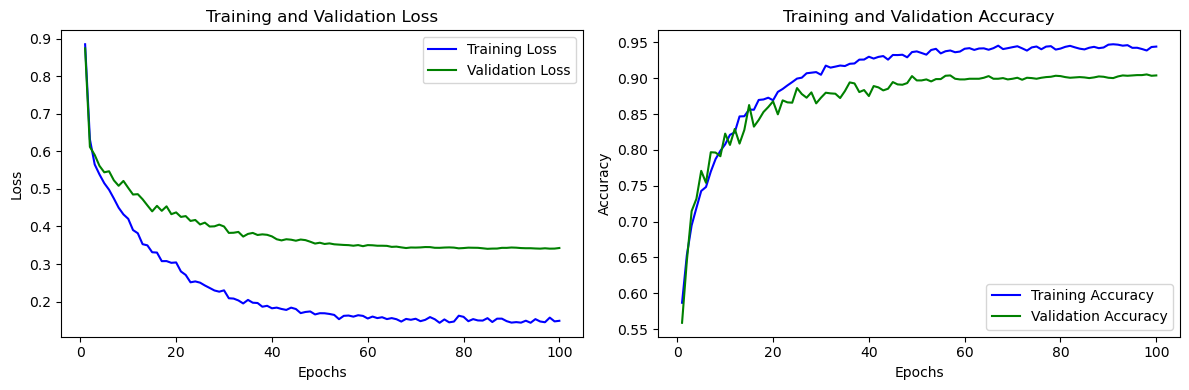

In [9]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict([X_test])
y_pred = np.round(y_pred).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

target_names = ['Control', 'Concussed']

print("Classification Report:")
print(classification_report(y_test, y_pred,target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


68/68 [==============================] - 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

     Control       0.89      0.92      0.91      1080
   Concussed       0.91      0.89      0.90      1076

    accuracy                           0.90      2156
   macro avg       0.90      0.90      0.90      2156
weighted avg       0.90      0.90      0.90      2156

Confusion Matrix:
[[991  89]
 [118 958]]


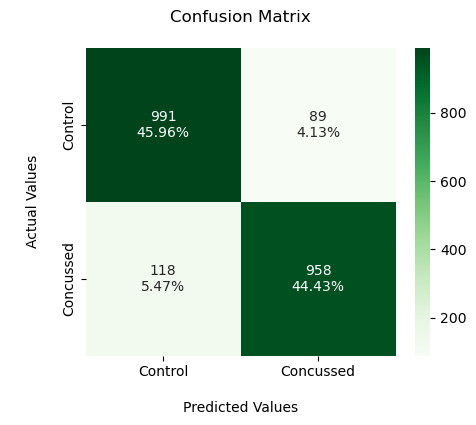

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred_binary = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, fmt='', annot=labels, cmap='Greens')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

plt.show()


68/68 [==============================] - 1s 13ms/step
ROC-AUC Score: 0.9642214821699022


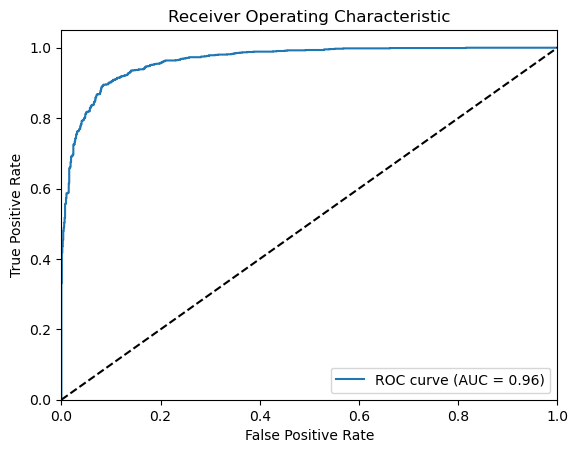

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict([X_test])
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
TP = 991
FN = 89
FP = 118
TN = 958

Precision = TP / (TP + FP)
Sensitivity = TP / (TP + FN)
Specificity = TN /(TN + FP)
False_Pos_Rate = FP / (TN + FP)
False_Neg_Rate = FN / (FN + TP)
F1_Score = (2*Precision*Sensitivity) / (Precision + Sensitivity)
Accuracy = (TP+TN) / (TP+FP+TN+FN)

precision = "{:.2f}".format(Precision)
sensitivity = "{:.2f}".format(Sensitivity)
specificity = "{:.2f}".format(Specificity)
false_pos_rate = "{:.2f}".format(False_Pos_Rate)
false_neg_rate = "{:.2f}".format(False_Neg_Rate)
f1_score = "{:.2f}".format(F1_Score)
accuracy = "{:.2f}".format(Accuracy)

print("Precision          :", precision)
print("Sensitivity        :", sensitivity)
print("Specificity        :", specificity)
print("F1-Score           :", f1_score)
print("False Positive Rate:", false_pos_rate)
print("False Negative Rate:", false_neg_rate)
print("Accuraccy          :", accuracy)

Precision          : 0.89
Sensitivity        : 0.92
Specificity        : 0.89
F1-Score           : 0.91
False Positive Rate: 0.11
False Negative Rate: 0.08
Accuraccy          : 0.90
